### Train and save a model

In [1]:
import pickle
import sys

# adapt paths
path_to_project = ""

sys.path.append(path_to_project + "benchmark_VAE/")
sys.path.append(path_to_project + "benchmark_VAE/src/")


from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models import BetaVAEgpCondInd
from pythae.models import (
    BetaVAEgpCondIndConfig,
)
from pythae.models.beta_vae_gp.encoder_decoder import (
    Indep_MLP_Decoder,
    Guidance_Classifier,
    LSTM_Encoder,
    LSTM_Retrodiction_Decoder,
)

from pythae.ssc.utils import (
    load_cv,
    get_classifier_config,
    remove_short_samples,
)

from pythae.models.beta_vae_gp.classifier_config import (
    EncoderDecoderConfig,
    PriorLatentConfig,
    DecoderConfig,
)
from pythae.models.beta_vae_gp.prior_latent import PriorLatent

import numpy as np
import torch
import random

from pythae.ssc.plots import plot_losses

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

# adapt path
data_path = path_to_project + "fake_data/processed/"
name = "_ml4h"

# load bodies and cohorts, they have to be generate first by running the ssc/create_cv.py script
with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, n_folds=2, name=name)

# variable names
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
weights_x0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "x"]
weights_y0 = [vW for i, vW in enumerate(var_weights0) if xyt0[i] == "y"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

input_size = sum(splits_x0)

static_size = sum(splits_s0)
latent_dim = 21
model_name = "VAE"

params = {
    "dropout": 0.1,
    "lstm_hidden_size": 100,
    "num_lstm_layers": 1,
    "hidden_dims_enc": [100, 100],
    "hidden_dims_emb_dec": [100],
    "hidden_dims_log_var_dec": [100],
    "classif_layers": [40],
}

# can be changed to train different models
sample_ = True
fixed_variance = False

# to create classifier configs. Specify each classifier name, variables to predict in y, z dimensions to use and architecture of the classifier
classifier_config = {
    "lung_inv": {
        "y_names": ["LUNG_ILD_involvement_or"],
        "z_dims": np.arange(0, 7),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "lung_stage": {
        "y_names": ["LUNG_ILD_stage_or"],
        "z_dims": np.arange(0, 7),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_inv": {
        "y_names": ["HEART_involvement_or"],
        "z_dims": np.arange(7, 14),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "heart_stage": {
        "y_names": ["HEART_stage_or"],
        "z_dims": np.arange(7, 14),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_inv": {
        "y_names": ["ARTHRITIS_involvement_or"],
        "z_dims": np.arange(14, 21),
        "layers": params["classif_layers"],
        "type": "static",
    },
    "arthritis_stage": {
        "y_names": ["ARTHRITIS_stage_or"],
        "z_dims": np.arange(14, 21),
        "layers": params["classif_layers"],
        "type": "static",
    },
}
# weights for the different losses
beta = 0.01
w_class = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}

w_recon = 1
w_class_pred = {
    "lung_inv": 0.2,
    "lung_stage": 0.2,
    "heart_inv": 0.2,
    "heart_stage": 0.2,
    "arthritis_inv": 0.2,
    "arthritis_stage": 0.2,
}


classifier_configs = get_classifier_config(names_y0, splits_y0, classifier_config)

encoder_config = EncoderDecoderConfig.from_dict(
    {
        "input_dim": input_size + static_size,
        "output_dim": latent_dim,
        "latent_dim": latent_dim,
        "hidden_dims": params["hidden_dims_enc"],
        "cond_dim_time_input": 1,
        "lstm_": True,
        "lstm_hidden_size": params["lstm_hidden_size"],
        "num_lstm_layers": params["num_lstm_layers"],
        "device": device,
        "dropout": params["dropout"],
        "predict": True,
    }
)
decoder_config = DecoderConfig.from_dict(
    {
        "latent_dim": latent_dim,
        "output_dim": input_size,
        "fixed_variance": fixed_variance,
        "hidden_dims": [],
        "hidden_dims_emb": params["hidden_dims_emb_dec"],
        "hidden_dims_log_var": params["hidden_dims_log_var_dec"],
        "cond_dim_time_latent": 1,
        "cond_dim_static_latent": static_size,
        "lstm_": False,
        "dropout": params["dropout"],
        "device": device,
    }
)

prior_config = PriorLatentConfig.from_dict(
    {
        "input_dim": 1 + static_size,
        "latent_dim": latent_dim,
        "hidden_dims": [50],
        "device": device,
        "dropout": params["dropout"],
    }
)

to_reconstruct_x = [(name, index, True) for index, name in enumerate(names_x0)]

to_reconstruct_y = [(name, index, True) for index, name in enumerate(names_y0)]
model_config = BetaVAEgpCondIndConfig(
    input_dim=(input_size,),
    sample=sample_,
    latent_dim=latent_dim,
    w_class=w_class,
    w_recon=w_recon,
    beta=beta,
    w_class_pred=w_class_pred,
    missing_loss=True,
    latent_prior_noise_var=1,
    classifier_config=classifier_configs,
    encoder_config=encoder_config,
    decoder_config=decoder_config,
    prior_config=prior_config,
    splits_x0=splits_x0,
    kinds_x0=kinds_x0,
    splits_y0=splits_y0,
    kinds_y0=kinds_y0,
    names_x0=names_x0,
    weights_x0=weights_x0,
    weights_y0=weights_y0,
    to_reconstruct_x=to_reconstruct_x,
    to_reconstruct_y=to_reconstruct_y,
    device=device,
    predict=True,
    retrodiction=False,
    progression=False,
)

k = 0
print(f"Training on fold {k}")

output_dir = "saved_models/model_fold_" + str(k) + "/"
config = BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=50,
    customized=True,
)

my_encoder = LSTM_Encoder(encoder_config)

if decoder_config.lstm_:
    my_decoder = LSTM_Retrodiction_Decoder(decoder_config)
else:
    my_decoder = Indep_MLP_Decoder(decoder_config)

if prior_config is not None:
    prior_latent = PriorLatent(prior_config)
else:
    prior_latent = None

my_classifiers = [
    Guidance_Classifier(config) for config in model_config.classifier_config
]

model = BetaVAEgpCondInd(
    model_config=model_config,
    encoder=my_encoder,
    decoder=my_decoder,
    classifiers=my_classifiers,
    prior_latent=prior_latent,
)

pipeline = TrainingPipeline(training_config=config, model=model)

Training on fold 0


In [3]:
# train model
pipeline(train_data=data_train_folds[k], eval_data=data_valid_folds[k])

Using customized Base Trainer

Model passed sanity check !

Created saved_models/model_fold_0/BetaVAEgpCondInd_training_2023-09-08_13-11-32. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.4717
Train loss CV: 3.4717
Train losses: tensor([2.2182, 0.9575, 0.0063, 0.1433, 0.2822, 0.1193, 0.2913, 0.1399, 0.2785])
Train loss CE all: 0.7713 Train loss nll all: 1.1671
Train losses unw: tensor([7.8551, 0.9575, 0.6253, 0.7164, 1.4108, 0.5964, 1.4567, 0.6997, 1.3923])
Train losses pred: tensor([2.2153, 0.9619, 0.1432, 0.2835, 0.1194, 0.2885, 0.1401, 0.2789])
Train loss CE recon pred: 0.7718 Train loss nll recon pred: 1.1758
Train losses unw pred: tensor([7.2291, 0.9619, 0.7159, 1.4173, 0.5968, 1.4424, 0.7005, 1.3943])
Eval loss: 3.4626
Eval loss CV: 3.4626
Eval losses: tensor([2.2134, 0.9641, 0.0045, 0.1418, 0.2817, 0.1183, 0.2862, 0.1400, 0.2767])
Eval loss CE recon: 0.7777 Eval loss nll recon: 1.1739
Eval losses unw: tensor([7.6401, 0.9641, 0.4523, 0.7090, 1.4084, 0.5917, 1.4309, 0.7000, 1.3837])
Eval losses pred: tensor([2.2126, 0.9634, 0.1418, 0.2828, 0.1188, 0.2883, 0.1401, 0.2774])
Eval 

Training of epoch 2/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.4116
Train loss CV: 3.4116
Train losses: tensor([2.1703, 0.9237, 0.0064, 0.1381, 0.2810, 0.1163, 0.2916, 0.1396, 0.2736])
Train loss CE all: 0.765 Train loss nll all: 1.1022
Train losses unw: tensor([7.7668, 0.9237, 0.6421, 0.6904, 1.4051, 0.5815, 1.4578, 0.6980, 1.3682])
Train losses pred: tensor([2.1674, 0.9261, 0.1385, 0.2822, 0.1167, 0.2902, 0.1395, 0.2742])
Train loss CE recon pred: 0.7647 Train loss nll recon pred: 1.1076
Train losses unw pred: tensor([7.1325, 0.9261, 0.6923, 1.4109, 0.5833, 1.4510, 0.6977, 1.3712])
Eval loss: 3.385
Eval loss CV: 3.385
Eval losses: tensor([2.1699, 0.9477, 0.0158, 0.1280, 0.2796, 0.1114, 0.2826, 0.1388, 0.2660])
Eval loss CE recon: 0.7777 Eval loss nll recon: 1.1391
Eval losses unw: tensor([8.5592, 0.9477, 1.5795, 0.6399, 1.3978, 0.5571, 1.4131, 0.6939, 1.3302])
Eval losses pred: tensor([2.1638, 0.9487, 0.1302, 0.2809, 0.1130, 0.2843, 0.1385, 0.2683])
Eval los

Training of epoch 3/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.3308
Train loss CV: 3.3308
Train losses: tensor([2.1493, 0.9093, 0.0694, 0.1114, 0.2799, 0.1015, 0.2851, 0.1376, 0.2551])
Train loss CE all: 0.7636 Train loss nll all: 1.0731
Train losses unw: tensor([13.7065,  0.9093,  6.9440,  0.5572,  1.3997,  0.5073,  1.4257,  0.6880,
         1.2753])
Train losses pred: tensor([2.0939, 0.9125, 0.1166, 0.2794, 0.1041, 0.2857, 0.1368, 0.2589])
Train loss CE recon pred: 0.7646 Train loss nll recon pred: 1.0788
Train losses unw pred: tensor([6.8199, 0.9125, 0.5829, 1.3971, 0.5204, 1.4283, 0.6842, 1.2945])
Eval loss: 3.3207
Eval loss CV: 3.3207
Eval losses: tensor([2.1570, 0.9205, 0.0905, 0.1039, 0.2769, 0.0948, 0.2809, 0.1372, 0.2523])
Eval loss CE recon: 0.7722 Eval loss nll recon: 1.0873
Eval losses unw: tensor([15.7015,  0.9205,  9.0508,  0.5196,  1.3844,  0.4739,  1.4045,  0.6861,
         1.2615])
Eval losses pred: tensor([2.0865, 0.9228, 0.1090, 0.2794, 0.09

Training of epoch 4/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2858
Train loss CV: 3.2858
Train losses: tensor([2.1178, 0.8969, 0.0641, 0.1080, 0.2781, 0.0961, 0.2839, 0.1374, 0.2533])
Train loss CE all: 0.7616 Train loss nll all: 1.049
Train losses unw: tensor([13.0909,  0.8969,  6.4096,  0.5402,  1.3906,  0.4803,  1.4196,  0.6870,
         1.2667])
Train losses pred: tensor([2.0684, 0.9004, 0.1131, 0.2785, 0.0992, 0.2830, 0.1369, 0.2574])
Train loss CE recon pred: 0.7618 Train loss nll recon pred: 1.0564
Train losses unw pred: tensor([6.7404, 0.9004, 0.5653, 1.3924, 0.4958, 1.4150, 0.6846, 1.2869])
Eval loss: 3.2895
Eval loss CV: 3.2895
Eval losses: tensor([2.1165, 0.9131, 0.0443, 0.1117, 0.2755, 0.0963, 0.2814, 0.1380, 0.2562])
Eval loss CE recon: 0.7689 Eval loss nll recon: 1.0752
Eval losses unw: tensor([11.1363,  0.9131,  4.4276,  0.5584,  1.3777,  0.4814,  1.4071,  0.6900,
         1.2811])
Eval losses pred: tensor([2.0885, 0.9154, 0.1146, 0.2786, 0.099

Training of epoch 5/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.2536
Train loss CV: 3.2536
Train losses: tensor([2.1003, 0.8917, 0.0662, 0.1030, 0.2783, 0.0885, 0.2836, 0.1369, 0.2521])
Train loss CE all: 0.759 Train loss nll all: 1.0411
Train losses unw: tensor([13.2214,  0.8917,  6.6175,  0.5150,  1.3915,  0.4424,  1.4181,  0.6845,
         1.2606])
Train losses pred: tensor([2.0484, 0.8951, 0.1082, 0.2778, 0.0920, 0.2824, 0.1368, 0.2560])
Train loss CE recon pred: 0.7596 Train loss nll recon pred: 1.0477
Train losses unw pred: tensor([6.6614, 0.8951, 0.5412, 1.3888, 0.4600, 1.4122, 0.6841, 1.2800])
Eval loss: 3.2529
Eval loss CV: 3.2529
Eval losses: tensor([2.1144, 0.9059, 0.0889, 0.0964, 0.2751, 0.0800, 0.2805, 0.1372, 0.2504])
Eval loss CE recon: 0.7678 Eval loss nll recon: 1.0612
Eval losses unw: tensor([15.3941,  0.9059,  8.8904,  0.4819,  1.3753,  0.4002,  1.4024,  0.6862,
         1.2519])
Eval losses pred: tensor([2.0481, 0.9095, 0.1008, 0.2783, 0.085

Training of epoch 6/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.228
Train loss CV: 3.228
Train losses: tensor([2.0905, 0.8855, 0.0789, 0.0965, 0.2787, 0.0798, 0.2860, 0.1372, 0.2480])
Train loss CE all: 0.7576 Train loss nll all: 1.0294
Train losses unw: tensor([14.4032,  0.8855,  7.8870,  0.4826,  1.3936,  0.3989,  1.4299,  0.6860,
         1.2398])
Train losses pred: tensor([2.0273, 0.8898, 0.1019, 0.2780, 0.0838, 0.2832, 0.1363, 0.2542])
Train loss CE recon pred: 0.7589 Train loss nll recon pred: 1.0371
Train losses unw pred: tensor([6.5773, 0.8898, 0.5094, 1.3901, 0.4191, 1.4162, 0.6817, 1.2710])
Eval loss: 3.2248
Eval loss CV: 3.2248
Eval losses: tensor([2.0817, 0.9008, 0.0557, 0.1011, 0.2747, 0.0806, 0.2805, 0.1369, 0.2514])
Eval loss CE recon: 0.7654 Eval loss nll recon: 1.0533
Eval losses unw: tensor([12.0927,  0.9008,  5.5658,  0.5054,  1.3737,  0.4032,  1.4025,  0.6844,
         1.2568])
Eval losses pred: tensor([2.0483, 0.9051, 0.1037, 0.2779, 0.0851

Training of epoch 7/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1962
Train loss CV: 3.1962
Train losses: tensor([2.0642, 0.8822, 0.0677, 0.0960, 0.2773, 0.0759, 0.2816, 0.1369, 0.2466])
Train loss CE all: 0.7563 Train loss nll all: 1.0238
Train losses unw: tensor([13.2244,  0.8822,  6.7705,  0.4802,  1.3866,  0.3796,  1.4078,  0.6847,
         1.2328])
Train losses pred: tensor([2.0201, 0.8882, 0.1004, 0.2783, 0.0799, 0.2839, 0.1362, 0.2532])
Train loss CE recon pred: 0.757 Train loss nll recon pred: 1.0358
Train losses unw pred: tensor([6.5479, 0.8882, 0.5021, 1.3915, 0.3997, 1.4195, 0.6808, 1.2661])
Eval loss: 3.1946
Eval loss CV: 3.1946
Eval losses: tensor([2.0703, 0.8967, 0.0717, 0.0944, 0.2730, 0.0715, 0.2795, 0.1369, 0.2466])
Eval loss CE recon: 0.7635 Eval loss nll recon: 1.0466
Eval losses unw: tensor([13.5723,  0.8967,  7.1657,  0.4719,  1.3652,  0.3574,  1.3977,  0.6845,
         1.2332])
Eval losses pred: tensor([2.0263, 0.9020, 0.0973, 0.2779, 0.076

Training of epoch 8/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.165
Train loss CV: 3.165
Train losses: tensor([2.0445, 0.8770, 0.0684, 0.0923, 0.2769, 0.0700, 0.2812, 0.1365, 0.2421])
Train loss CE all: 0.7546 Train loss nll all: 1.0147
Train losses unw: tensor([13.2169,  0.8770,  6.8447,  0.4615,  1.3844,  0.3498,  1.4062,  0.6827,
         1.2105])
Train losses pred: tensor([2.0050, 0.8845, 0.0960, 0.2776, 0.0740, 0.2840, 0.1364, 0.2524])
Train loss CE recon pred: 0.7558 Train loss nll recon pred: 1.0293
Train losses unw pred: tensor([6.4872, 0.8845, 0.4801, 1.3882, 0.3701, 1.4202, 0.6820, 1.2620])
Eval loss: 3.1679
Eval loss CV: 3.1679
Eval losses: tensor([2.0505, 0.8928, 0.0633, 0.0920, 0.2736, 0.0676, 0.2793, 0.1369, 0.2450])
Eval loss CE recon: 0.7625 Eval loss nll recon: 1.0393
Eval losses unw: tensor([12.6929,  0.8928,  6.3278,  0.4600,  1.3678,  0.3382,  1.3967,  0.6846,
         1.2249])
Eval losses pred: tensor([2.0192, 0.9019, 0.0934, 0.2788, 0.0719

Training of epoch 9/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.138
Train loss CV: 3.138
Train losses: tensor([2.0332, 0.8743, 0.0709, 0.0881, 0.2769, 0.0648, 0.2819, 0.1364, 0.2400])
Train loss CE all: 0.7541 Train loss nll all: 1.0094
Train losses unw: tensor([13.4057,  0.8743,  7.0912,  0.4406,  1.3844,  0.3242,  1.4093,  0.6818,
         1.2001])
Train losses pred: tensor([1.9894, 0.8847, 0.0911, 0.2775, 0.0676, 0.2827, 0.1361, 0.2498])
Train loss CE recon pred: 0.7554 Train loss nll recon pred: 1.0301
Train losses unw pred: tensor([6.4085, 0.8847, 0.4554, 1.3874, 0.3379, 1.4133, 0.6807, 1.2491])
Eval loss: 3.1354
Eval loss CV: 3.1354
Eval losses: tensor([2.0291, 0.8873, 0.0578, 0.0903, 0.2723, 0.0655, 0.2777, 0.1365, 0.2418])
Eval loss CE recon: 0.7618 Eval loss nll recon: 1.0284
Eval losses unw: tensor([12.0878,  0.8873,  5.7802,  0.4513,  1.3617,  0.3277,  1.3883,  0.6823,
         1.2090])
Eval losses pred: tensor([2.0062, 0.8999, 0.0901, 0.2782, 0.0686

Training of epoch 10/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.1093
Train loss CV: 3.1093
Train losses: tensor([2.0106, 0.8679, 0.0638, 0.0861, 0.2767, 0.0628, 0.2802, 0.1361, 0.2369])
Train loss CE all: 0.7531 Train loss nll all: 0.997
Train losses unw: tensor([12.6463,  0.8679,  6.3842,  0.4303,  1.3835,  0.3141,  1.4012,  0.6806,
         1.1846])
Train losses pred: tensor([1.9790, 0.8802, 0.0878, 0.2782, 0.0645, 0.2831, 0.1365, 0.2487])
Train loss CE recon pred: 0.7552 Train loss nll recon pred: 1.0209
Train losses unw pred: tensor([6.3740, 0.8802, 0.4388, 1.3910, 0.3225, 1.4156, 0.6824, 1.2434])
Eval loss: 3.1066
Eval loss CV: 3.1066
Eval losses: tensor([2.0082, 0.8818, 0.0591, 0.0867, 0.2711, 0.0605, 0.2755, 0.1364, 0.2373])
Eval loss CE recon: 0.7606 Eval loss nll recon: 1.0181
Eval losses unw: tensor([12.1275,  0.8818,  5.9089,  0.4333,  1.3553,  0.3025,  1.3775,  0.6819,
         1.1864])
Eval losses pred: tensor([2.0013, 0.9029, 0.0852, 0.2799, 0.063

Training of epoch 11/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0753
Train loss CV: 3.0753
Train losses: tensor([1.9900, 0.8631, 0.0638, 0.0840, 0.2743, 0.0579, 0.2787, 0.1363, 0.2320])
Train loss CE all: 0.7515 Train loss nll all: 0.9886
Train losses unw: tensor([12.5605,  0.8631,  6.3817,  0.4200,  1.3715,  0.2895,  1.3933,  0.6814,
         1.1601])
Train losses pred: tensor([1.9677, 0.8824, 0.0831, 0.2780, 0.0585, 0.2816, 0.1366, 0.2474])
Train loss CE recon pred: 0.7545 Train loss nll recon pred: 1.0264
Train losses unw pred: tensor([6.3088, 0.8824, 0.4157, 1.3900, 0.2925, 1.4078, 0.6832, 1.2371])
Eval loss: 3.0796
Eval loss CV: 3.0796
Eval losses: tensor([1.9925, 0.8757, 0.0622, 0.0845, 0.2692, 0.0556, 0.2754, 0.1359, 0.2340])
Eval loss CE recon: 0.759 Eval loss nll recon: 1.007
Eval losses unw: tensor([12.3713,  0.8757,  6.2229,  0.4223,  1.3458,  0.2781,  1.3771,  0.6794,
         1.1701])
Eval losses pred: tensor([1.9894, 0.9023, 0.0820, 0.2796, 0.0576

Training of epoch 12/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0481
Train loss CV: 3.0481
Train losses: tensor([1.9723, 0.8570, 0.0662, 0.0821, 0.2732, 0.0534, 0.2761, 0.1358, 0.2285])
Train loss CE all: 0.749 Train loss nll all: 0.9785
Train losses unw: tensor([12.7192,  0.8570,  6.6162,  0.4106,  1.3662,  0.2668,  1.3807,  0.6792,
         1.1425])
Train losses pred: tensor([1.9584, 0.8826, 0.0802, 0.2780, 0.0536, 0.2824, 0.1359, 0.2456])
Train loss CE recon pred: 0.7542 Train loss nll recon pred: 1.0272
Train losses unw pred: tensor([6.2613, 0.8826, 0.4011, 1.3901, 0.2679, 1.4121, 0.6796, 1.2280])
Eval loss: 3.0525
Eval loss CV: 3.0525
Eval losses: tensor([1.9727, 0.8683, 0.0623, 0.0818, 0.2689, 0.0521, 0.2732, 0.1353, 0.2308])
Eval loss CE recon: 0.7564 Eval loss nll recon: 0.9942
Eval losses unw: tensor([12.3054,  0.8683,  6.2265,  0.4092,  1.3443,  0.2604,  1.3662,  0.6765,
         1.1539])
Eval losses pred: tensor([1.9816, 0.9018, 0.0787, 0.2809, 0.053

Training of epoch 13/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3.0145
Train loss CV: 3.0145
Train losses: tensor([1.9493, 0.8506, 0.0675, 0.0781, 0.2719, 0.0507, 0.2704, 0.1347, 0.2253])
Train loss CE all: 0.7464 Train loss nll all: 0.968
Train losses unw: tensor([12.7526,  0.8506,  6.7460,  0.3907,  1.3593,  0.2537,  1.3521,  0.6736,
         1.1266])
Train losses pred: tensor([1.9476, 0.8823, 0.0774, 0.2769, 0.0497, 0.2797, 0.1367, 0.2448])
Train loss CE recon pred: 0.7529 Train loss nll recon pred: 1.028
Train losses unw pred: tensor([6.2086, 0.8823, 0.3871, 1.3846, 0.2484, 1.3987, 0.6836, 1.2238])
Eval loss: 3.0283
Eval loss CV: 3.0283
Eval losses: tensor([1.9553, 0.8633, 0.0655, 0.0791, 0.2661, 0.0484, 0.2699, 0.1348, 0.2282])
Eval loss CE recon: 0.7553 Eval loss nll recon: 0.9847
Eval losses unw: tensor([12.5507,  0.8633,  6.5548,  0.3956,  1.3304,  0.2421,  1.3497,  0.6741,
         1.1408])
Eval losses pred: tensor([1.9779, 0.9049, 0.0760, 0.2803, 0.0496

Training of epoch 14/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.993
Train loss CV: 2.993
Train losses: tensor([1.9284, 0.8424, 0.0676, 0.0763, 0.2707, 0.0485, 0.2636, 0.1342, 0.2250])
Train loss CE all: 0.744 Train loss nll all: 0.9532
Train losses unw: tensor([12.6970,  0.8424,  6.7630,  0.3817,  1.3536,  0.2424,  1.3181,  0.6709,
         1.1248])
Train losses pred: tensor([1.9447, 0.8801, 0.0752, 0.2808, 0.0476, 0.2802, 0.1363, 0.2444])
Train loss CE recon pred: 0.7538 Train loss nll recon pred: 1.0221
Train losses unw pred: tensor([6.2031, 0.8801, 0.3760, 1.4040, 0.2379, 1.4012, 0.6817, 1.2222])
Eval loss: 3.0012
Eval loss CV: 3.0012
Eval losses: tensor([1.9338, 0.8572, 0.0643, 0.0780, 0.2652, 0.0466, 0.2618, 0.1343, 0.2265])
Eval loss CE recon: 0.7529 Eval loss nll recon: 0.9745
Eval losses unw: tensor([12.3469,  0.8572,  6.4279,  0.3902,  1.3259,  0.2328,  1.3089,  0.6716,
         1.1326])
Eval losses pred: tensor([1.9725, 0.9051, 0.0747, 0.2802, 0.0479,

Training of epoch 15/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9716
Train loss CV: 2.9716
Train losses: tensor([1.9122, 0.8398, 0.0706, 0.0754, 0.2700, 0.0457, 0.2549, 0.1338, 0.2221])
Train loss CE all: 0.7409 Train loss nll all: 0.951
Train losses unw: tensor([12.9080,  0.8398,  7.0589,  0.3769,  1.3500,  0.2283,  1.2744,  0.6692,
         1.1105])
Train losses pred: tensor([1.9455, 0.8861, 0.0745, 0.2791, 0.0451, 0.2786, 0.1367, 0.2455])
Train loss CE recon pred: 0.754 Train loss nll recon pred: 1.0346
Train losses unw pred: tensor([6.1831, 0.8861, 0.3724, 1.3953, 0.2253, 1.3931, 0.6835, 1.2273])
Eval loss: 2.9787
Eval loss CV: 2.9787
Eval losses: tensor([1.9142, 0.8489, 0.0648, 0.0776, 0.2638, 0.0453, 0.2544, 0.1341, 0.2253])
Eval loss CE recon: 0.7487 Eval loss nll recon: 0.9617
Eval losses unw: tensor([12.3300,  0.8489,  6.4784,  0.3881,  1.3190,  0.2264,  1.2720,  0.6705,
         1.1267])
Eval losses pred: tensor([1.9660, 0.9015, 0.0741, 0.2794, 0.0470

Training of epoch 16/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9447
Train loss CV: 2.9447
Train losses: tensor([1.8903, 0.8306, 0.0748, 0.0745, 0.2674, 0.0439, 0.2445, 0.1338, 0.2208])
Train loss CE all: 0.7366 Train loss nll all: 0.9363
Train losses unw: tensor([13.2340,  0.8306,  7.4788,  0.3727,  1.3370,  0.2194,  1.2223,  0.6692,
         1.1040])
Train losses pred: tensor([1.9391, 0.8847, 0.0743, 0.2766, 0.0440, 0.2782, 0.1364, 0.2449])
Train loss CE recon pred: 0.7536 Train loss nll recon pred: 1.0323
Train losses unw pred: tensor([6.1568, 0.8847, 0.3717, 1.3828, 0.2199, 1.3909, 0.6820, 1.2247])
Eval loss: 2.9576
Eval loss CV: 2.9576
Eval losses: tensor([1.8963, 0.8453, 0.0654, 0.0776, 0.2622, 0.0452, 0.2421, 0.1336, 0.2248])
Eval loss CE recon: 0.7446 Eval loss nll recon: 0.9587
Eval losses unw: tensor([12.3158,  0.8453,  6.5428,  0.3880,  1.3109,  0.2262,  1.2103,  0.6681,
         1.1241])
Eval losses pred: tensor([1.9647, 0.9034, 0.0739, 0.2791, 0.04

Training of epoch 17/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.9173
Train loss CV: 2.9173
Train losses: tensor([1.8684, 0.8235, 0.0763, 0.0744, 0.2676, 0.0431, 0.2320, 0.1332, 0.2183])
Train loss CE all: 0.733 Train loss nll all: 0.9253
Train losses unw: tensor([13.2954,  0.8235,  7.6288,  0.3719,  1.3382,  0.2155,  1.1601,  0.6661,
         1.0914])
Train losses pred: tensor([1.9321, 0.8831, 0.0725, 0.2779, 0.0425, 0.2751, 0.1359, 0.2449])
Train loss CE recon pred: 0.7532 Train loss nll recon pred: 1.0293
Train losses unw pred: tensor([6.1279, 0.8831, 0.3627, 1.3897, 0.2125, 1.3757, 0.6794, 1.2246])
Eval loss: 2.934
Eval loss CV: 2.934
Eval losses: tensor([1.8767, 0.8425, 0.0619, 0.0776, 0.2616, 0.0451, 0.2335, 0.1335, 0.2210])
Eval loss CE recon: 0.7421 Eval loss nll recon: 0.9555
Eval losses unw: tensor([11.8943,  0.8425,  6.1905,  0.3878,  1.3081,  0.2257,  1.1674,  0.6674,
         1.1048])
Eval losses pred: tensor([1.9631, 0.9059, 0.0740, 0.2779, 0.0463,

Training of epoch 18/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8816
Train loss CV: 2.8816
Train losses: tensor([1.8399, 0.8184, 0.0768, 0.0726, 0.2661, 0.0415, 0.2185, 0.1336, 0.2125])
Train loss CE all: 0.729 Train loss nll all: 0.9189
Train losses unw: tensor([13.2184,  0.8184,  7.6763,  0.3629,  1.3303,  0.2073,  1.0926,  0.6681,
         1.0627])
Train losses pred: tensor([1.9248, 0.8832, 0.0718, 0.2770, 0.0416, 0.2697, 0.1366, 0.2448])
Train loss CE recon pred: 0.7519 Train loss nll recon pred: 1.0308
Train losses unw pred: tensor([6.0915, 0.8832, 0.3590, 1.3852, 0.2082, 1.3487, 0.6831, 1.2241])
Eval loss: 2.8965
Eval loss CV: 2.8965
Eval losses: tensor([1.8447, 0.8316, 0.0659, 0.0756, 0.2598, 0.0431, 0.2221, 0.1335, 0.2131])
Eval loss CE recon: 0.7386 Eval loss nll recon: 0.9364
Eval losses unw: tensor([12.1603,  0.8316,  6.5929,  0.3782,  1.2989,  0.2154,  1.1104,  0.6674,
         1.0654])
Eval losses pred: tensor([1.9522, 0.9004, 0.0725, 0.2782, 0.044

Training of epoch 19/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8472
Train loss CV: 2.8472
Train losses: tensor([1.8131, 0.8130, 0.0815, 0.0712, 0.2632, 0.0408, 0.2035, 0.1329, 0.2069])
Train loss CE all: 0.7254 Train loss nll all: 0.9116
Train losses unw: tensor([13.5542,  0.8130,  8.1481,  0.3561,  1.3162,  0.2040,  1.0176,  0.6647,
         1.0344])
Train losses pred: tensor([1.9192, 0.8851, 0.0718, 0.2769, 0.0400, 0.2639, 0.1366, 0.2450])
Train loss CE recon pred: 0.751 Train loss nll recon pred: 1.0359
Train losses unw pred: tensor([6.0558, 0.8851, 0.3590, 1.3843, 0.2000, 1.3193, 0.6830, 1.2251])
Eval loss: 2.867
Eval loss CV: 2.867
Eval losses: tensor([1.8218, 0.8257, 0.0753, 0.0735, 0.2575, 0.0409, 0.2107, 0.1331, 0.2050])
Eval loss CE recon: 0.7342 Eval loss nll recon: 0.9287
Eval losses unw: tensor([12.9628,  0.8257,  7.5333,  0.3674,  1.2876,  0.2044,  1.0535,  0.6657,
         1.0252])
Eval losses pred: tensor([1.9520, 0.9067, 0.0707, 0.2789, 0.0437,

Training of epoch 20/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.8185
Train loss CV: 2.8185
Train losses: tensor([1.7923, 0.8029, 0.0866, 0.0707, 0.2600, 0.0407, 0.1990, 0.1325, 0.1998])
Train loss CE all: 0.7209 Train loss nll all: 0.8952
Train losses unw: tensor([13.9780,  0.8029,  8.6610,  0.3535,  1.3001,  0.2036,  0.9951,  0.6627,
         0.9992])
Train losses pred: tensor([1.9061, 0.8799, 0.0705, 0.2765, 0.0403, 0.2581, 0.1368, 0.2440])
Train loss CE recon pred: 0.7466 Train loss nll recon pred: 1.0298
Train losses unw pred: tensor([6.0108, 0.8799, 0.3526, 1.3826, 0.2015, 1.2905, 0.6839, 1.2199])
Eval loss: 2.8265
Eval loss CV: 2.8265
Eval losses: tensor([1.7917, 0.8134, 0.0822, 0.0730, 0.2523, 0.0407, 0.1997, 0.1325, 0.1979])
Eval loss CE recon: 0.7299 Eval loss nll recon: 0.9073
Eval losses unw: tensor([13.5127,  0.8134,  8.2186,  0.3648,  1.2616,  0.2037,  0.9983,  0.6627,
         0.9896])
Eval losses pred: tensor([1.9343, 0.8996, 0.0703, 0.2765, 0.04

Training of epoch 21/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7825
Train loss CV: 2.7825
Train losses: tensor([1.7690, 0.8009, 0.0920, 0.0704, 0.2542, 0.0407, 0.1853, 0.1321, 0.1934])
Train loss CE all: 0.7172 Train loss nll all: 0.8949
Train losses unw: tensor([14.3816,  0.8009,  9.2000,  0.3522,  1.2709,  0.2033,  0.9267,  0.6604,
         0.9672])
Train losses pred: tensor([1.8993, 0.8858, 0.0706, 0.2743, 0.0403, 0.2488, 0.1361, 0.2432])
Train loss CE recon pred: 0.7455 Train loss nll recon pred: 1.0437
Train losses unw pred: tensor([5.9532, 0.8858, 0.3532, 1.3716, 0.2017, 1.2441, 0.6807, 1.2161])
Eval loss: 2.8063
Eval loss CV: 2.8063
Eval losses: tensor([1.7784, 0.8163, 0.0892, 0.0717, 0.2455, 0.0397, 0.1896, 0.1320, 0.1944])
Eval loss CE recon: 0.7259 Eval loss nll recon: 0.918
Eval losses unw: tensor([14.0976,  0.8163,  8.9167,  0.3583,  1.2276,  0.1987,  0.9478,  0.6602,
         0.9720])
Eval losses pred: tensor([1.9382, 0.9102, 0.0694, 0.2752, 0.042

Training of epoch 22/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7473
Train loss CV: 2.7473
Train losses: tensor([1.7387, 0.7943, 0.0944, 0.0707, 0.2458, 0.0395, 0.1742, 0.1320, 0.1879])
Train loss CE all: 0.7135 Train loss nll all: 0.8851
Train losses unw: tensor([14.4822,  0.7943,  9.4374,  0.3537,  1.2289,  0.1976,  0.8708,  0.6602,
         0.9393])
Train losses pred: tensor([1.8896, 0.8811, 0.0715, 0.2739, 0.0396, 0.2429, 0.1372, 0.2433])
Train loss CE recon pred: 0.7438 Train loss nll recon pred: 1.0356
Train losses unw pred: tensor([5.9238, 0.8811, 0.3577, 1.3697, 0.1979, 1.2147, 0.6860, 1.2167])
Eval loss: 2.767
Eval loss CV: 2.767
Eval losses: tensor([1.7419, 0.8018, 0.0850, 0.0726, 0.2386, 0.0397, 0.1813, 0.1315, 0.1914])
Eval loss CE recon: 0.722 Eval loss nll recon: 0.8915
Eval losses unw: tensor([13.5814,  0.8018,  8.5042,  0.3631,  1.1929,  0.1985,  0.9065,  0.6574,
         0.9570])
Eval losses pred: tensor([1.9211, 0.8959, 0.0710, 0.2752, 0.0425,

Training of epoch 23/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.7119
Train loss CV: 2.7119
Train losses: tensor([1.7132, 0.7887, 0.0999, 0.0698, 0.2347, 0.0401, 0.1632, 0.1308, 0.1859])
Train loss CE all: 0.7085 Train loss nll all: 0.879
Train losses unw: tensor([14.9004,  0.7887,  9.9888,  0.3490,  1.1735,  0.2006,  0.8161,  0.6541,
         0.9296])
Train losses pred: tensor([1.8768, 0.8781, 0.0703, 0.2729, 0.0388, 0.2376, 0.1365, 0.2425])
Train loss CE recon pred: 0.7401 Train loss nll recon pred: 1.0334
Train losses unw pred: tensor([5.8717, 0.8781, 0.3517, 1.3646, 0.1942, 1.1880, 0.6825, 1.2126])
Eval loss: 2.7358
Eval loss CV: 2.7358
Eval losses: tensor([1.7190, 0.8009, 0.0924, 0.0722, 0.2253, 0.0402, 0.1689, 0.1308, 0.1884])
Eval loss CE recon: 0.7197 Eval loss nll recon: 0.8923
Eval losses unw: tensor([14.1715,  0.8009,  9.2423,  0.3608,  1.1263,  0.2008,  0.8443,  0.6540,
         0.9421])
Eval losses pred: tensor([1.9142, 0.8974, 0.0704, 0.2736, 0.042

Training of epoch 24/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6732
Train loss CV: 2.6732
Train losses: tensor([1.6852, 0.7844, 0.1060, 0.0675, 0.2208, 0.0389, 0.1540, 0.1301, 0.1835])
Train loss CE all: 0.7073 Train loss nll all: 0.8711
Train losses unw: tensor([15.3555,  0.7844, 10.5970,  0.3377,  1.1040,  0.1943,  0.7700,  0.6505,
         0.9175])
Train losses pred: tensor([1.8672, 0.8791, 0.0699, 0.2701, 0.0389, 0.2291, 0.1373, 0.2426])
Train loss CE recon pred: 0.7405 Train loss nll recon pred: 1.0351
Train losses unw pred: tensor([5.8192, 0.8791, 0.3496, 1.3506, 0.1947, 1.1454, 0.6865, 1.2132])
Eval loss: 2.7029
Eval loss CV: 2.7029
Eval losses: tensor([1.6890, 0.7973, 0.0990, 0.0703, 0.2121, 0.0403, 0.1545, 0.1294, 0.1861])
Eval loss CE recon: 0.7154 Eval loss nll recon: 0.8894
Eval losses unw: tensor([14.6575,  0.7973,  9.8967,  0.3517,  1.0605,  0.2015,  0.7724,  0.6472,
         0.9303])
Eval losses pred: tensor([1.9104, 0.8965, 0.0699, 0.2717, 0.04

Training of epoch 25/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6392
Train loss CV: 2.6392
Train losses: tensor([1.6520, 0.7798, 0.1148, 0.0677, 0.2071, 0.0390, 0.1340, 0.1287, 0.1808])
Train loss CE all: 0.7015 Train loss nll all: 0.8679
Train losses unw: tensor([16.0480,  0.7798, 11.4815,  0.3386,  1.0355,  0.1952,  0.6699,  0.6437,
         0.9038])
Train losses pred: tensor([1.8649, 0.8777, 0.0703, 0.2686, 0.0395, 0.2280, 0.1370, 0.2439])
Train loss CE recon pred: 0.7376 Train loss nll recon pred: 1.0353
Train losses unw pred: tensor([5.8138, 0.8777, 0.3514, 1.3429, 0.1974, 1.1400, 0.6850, 1.2195])
Eval loss: 2.6863
Eval loss CV: 2.6863
Eval losses: tensor([1.6847, 0.7943, 0.1098, 0.0701, 0.2082, 0.0396, 0.1508, 0.1287, 0.1833])
Eval loss CE recon: 0.7128 Eval loss nll recon: 0.886
Eval losses unw: tensor([15.6779,  0.7943, 10.9806,  0.3507,  1.0408,  0.1979,  0.7539,  0.6433,
         0.9165])
Eval losses pred: tensor([1.8932, 0.8916, 0.0704, 0.2719, 0.042

Training of epoch 26/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.6062
Train loss CV: 2.6062
Train losses: tensor([1.6309, 0.7751, 0.1194, 0.0679, 0.2011, 0.0389, 0.1234, 0.1280, 0.1772])
Train loss CE all: 0.6989 Train loss nll all: 0.8608
Train losses unw: tensor([16.3960,  0.7751, 11.9385,  0.3397,  1.0055,  0.1943,  0.6168,  0.6399,
         0.8862])
Train losses pred: tensor([1.8518, 0.8765, 0.0701, 0.2697, 0.0382, 0.2171, 0.1371, 0.2431])
Train loss CE recon pred: 0.7366 Train loss nll recon pred: 1.0339
Train losses unw pred: tensor([5.7531, 0.8765, 0.3504, 1.3487, 0.1909, 1.0855, 0.6854, 1.2156])
Eval loss: 2.6426
Eval loss CV: 2.6426
Eval losses: tensor([1.6429, 0.7883, 0.1091, 0.0673, 0.1990, 0.0386, 0.1335, 0.1277, 0.1794])
Eval loss CE recon: 0.7099 Eval loss nll recon: 0.8765
Eval losses unw: tensor([15.4215,  0.7883, 10.9055,  0.3366,  0.9951,  0.1928,  0.6676,  0.6386,
         0.8970])
Eval losses pred: tensor([1.8924, 0.8927, 0.0689, 0.2713, 0.04

Training of epoch 27/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5674
Train loss CV: 2.5674
Train losses: tensor([1.5967, 0.7683, 0.1210, 0.0647, 0.1947, 0.0395, 0.1067, 0.1274, 0.1744])
Train loss CE all: 0.6939 Train loss nll all: 0.852
Train losses unw: tensor([16.4030,  0.7683, 12.0978,  0.3236,  0.9733,  0.1975,  0.5336,  0.6369,
         0.8720])
Train losses pred: tensor([1.8436, 0.8729, 0.0694, 0.2676, 0.0399, 0.2126, 0.1377, 0.2434])
Train loss CE recon pred: 0.733 Train loss nll recon pred: 1.0302
Train losses unw pred: tensor([5.7266, 0.8729, 0.3470, 1.3380, 0.1997, 1.0631, 0.6886, 1.2172])
Eval loss: 2.6127
Eval loss CV: 2.6127
Eval losses: tensor([1.6165, 0.7856, 0.1110, 0.0671, 0.1910, 0.0388, 0.1186, 0.1271, 0.1772])
Eval loss CE recon: 0.7061 Eval loss nll recon: 0.875
Eval losses unw: tensor([15.4834,  0.7856, 11.0986,  0.3355,  0.9552,  0.1939,  0.5932,  0.6357,
         0.8858])
Eval losses pred: tensor([1.8869, 0.8907, 0.0691, 0.2701, 0.0416,

Training of epoch 28/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.541
Train loss CV: 2.541
Train losses: tensor([1.5792, 0.7667, 0.1241, 0.0648, 0.1891, 0.0393, 0.0959, 0.1267, 0.1725])
Train loss CE all: 0.6928 Train loss nll all: 0.8498
Train losses unw: tensor([16.6197,  0.7667, 12.4110,  0.3241,  0.9455,  0.1966,  0.4797,  0.6337,
         0.8625])
Train losses pred: tensor([1.8343, 0.8725, 0.0685, 0.2643, 0.0390, 0.2085, 0.1379, 0.2436])
Train loss CE recon pred: 0.7329 Train loss nll recon pred: 1.0296
Train losses unw pred: tensor([5.6814, 0.8725, 0.3426, 1.3215, 0.1950, 1.0426, 0.6894, 1.2179])
Eval loss: 2.5849
Eval loss CV: 2.5849
Eval losses: tensor([1.5978, 0.7828, 0.1171, 0.0662, 0.1887, 0.0388, 0.1038, 0.1262, 0.1742])
Eval loss CE recon: 0.7033 Eval loss nll recon: 0.8723
Eval losses unw: tensor([15.9816,  0.7828, 11.7092,  0.3311,  0.9437,  0.1941,  0.5189,  0.6308,
         0.8709])
Eval losses pred: tensor([1.8797, 0.8926, 0.0685, 0.2676, 0.0414

Training of epoch 29/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.5104
Train loss CV: 2.5104
Train losses: tensor([1.5555, 0.7635, 0.1274, 0.0637, 0.1853, 0.0377, 0.0820, 0.1257, 0.1702])
Train loss CE all: 0.6897 Train loss nll all: 0.8465
Train losses unw: tensor([16.8311,  0.7635, 12.7447,  0.3184,  0.9267,  0.1884,  0.4098,  0.6287,
         0.8509])
Train losses pred: tensor([1.8261, 0.8712, 0.0683, 0.2644, 0.0375, 0.2045, 0.1375, 0.2426])
Train loss CE recon pred: 0.7317 Train loss nll recon pred: 1.0281
Train losses unw pred: tensor([5.6455, 0.8712, 0.3417, 1.3222, 0.1876, 1.0223, 0.6874, 1.2130])
Eval loss: 2.5658
Eval loss CV: 2.5658
Eval losses: tensor([1.5892, 0.7797, 0.1294, 0.0663, 0.1843, 0.0396, 0.0918, 0.1249, 0.1732])
Eval loss CE recon: 0.7002 Eval loss nll recon: 0.8692
Eval losses unw: tensor([17.1211,  0.7797, 12.9413,  0.3313,  0.9215,  0.1981,  0.4588,  0.6246,
         0.8658])
Eval losses pred: tensor([1.8642, 0.8876, 0.0685, 0.2640, 0.04

Training of epoch 30/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4962
Train loss CV: 2.4962
Train losses: tensor([1.5472, 0.7639, 0.1351, 0.0652, 0.1821, 0.0380, 0.0701, 0.1241, 0.1687])
Train loss CE all: 0.6874 Train loss nll all: 0.8499
Train losses unw: tensor([17.5194,  0.7639, 13.5146,  0.3259,  0.9107,  0.1900,  0.3506,  0.6203,
         0.8433])
Train losses pred: tensor([1.8236, 0.8747, 0.0689, 0.2638, 0.0381, 0.1971, 0.1374, 0.2436])
Train loss CE recon pred: 0.7315 Train loss nll recon pred: 1.0358
Train losses unw pred: tensor([5.6194, 0.8747, 0.3447, 1.3191, 0.1905, 0.9857, 0.6868, 1.2179])
Eval loss: 2.5453
Eval loss CV: 2.5453
Eval losses: tensor([1.5699, 0.7780, 0.1247, 0.0658, 0.1833, 0.0392, 0.0849, 0.1233, 0.1707])
Eval loss CE recon: 0.6987 Eval loss nll recon: 0.8672
Eval losses unw: tensor([16.5812,  0.7780, 12.4672,  0.3292,  0.9165,  0.1958,  0.4245,  0.6163,
         0.8537])
Eval losses pred: tensor([1.8639, 0.8884, 0.0684, 0.2631, 0.04

Training of epoch 31/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4708
Train loss CV: 2.4708
Train losses: tensor([1.5231, 0.7612, 0.1317, 0.0641, 0.1792, 0.0378, 0.0610, 0.1225, 0.1658])
Train loss CE all: 0.6851 Train loss nll all: 0.8468
Train losses unw: tensor([17.0827,  0.7612, 13.1704,  0.3204,  0.8958,  0.1888,  0.3050,  0.6124,
         0.8288])
Train losses pred: tensor([1.8197, 0.8720, 0.0695, 0.2614, 0.0387, 0.1983, 0.1375, 0.2423])
Train loss CE recon pred: 0.7302 Train loss nll recon pred: 1.0316
Train losses unw pred: tensor([5.6102, 0.8720, 0.3473, 1.3071, 0.1936, 0.9916, 0.6873, 1.2113])
Eval loss: 2.5167
Eval loss CV: 2.5167
Eval losses: tensor([1.5470, 0.7776, 0.1230, 0.0647, 0.1815, 0.0390, 0.0709, 0.1218, 0.1686])
Eval loss CE recon: 0.6955 Eval loss nll recon: 0.8699
Eval losses unw: tensor([16.3107,  0.7776, 12.3010,  0.3234,  0.9075,  0.1949,  0.3543,  0.6091,
         0.8429])
Eval losses pred: tensor([1.8625, 0.8929, 0.0675, 0.2632, 0.04

Training of epoch 32/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4383
Train loss CV: 2.4383
Train losses: tensor([1.5072, 0.7585, 0.1371, 0.0626, 0.1751, 0.0382, 0.0508, 0.1212, 0.1636])
Train loss CE all: 0.6812 Train loss nll all: 0.8455
Train losses unw: tensor([17.5246,  0.7585, 13.7082,  0.3130,  0.8754,  0.1911,  0.2542,  0.6059,
         0.8182])
Train losses pred: tensor([1.8009, 0.8698, 0.0690, 0.2577, 0.0382, 0.1841, 0.1378, 0.2443])
Train loss CE recon pred: 0.7255 Train loss nll recon pred: 1.0321
Train losses unw pred: tensor([5.5255, 0.8698, 0.3450, 1.2885, 0.1909, 0.9207, 0.6890, 1.2216])
Eval loss: 2.4945
Eval loss CV: 2.4945
Eval losses: tensor([1.5250, 0.7742, 0.1292, 0.0638, 0.1767, 0.0388, 0.0571, 0.1194, 0.1659])
Eval loss CE recon: 0.6935 Eval loss nll recon: 0.8649
Eval losses unw: tensor([16.7987,  0.7742, 12.9162,  0.3188,  0.8837,  0.1938,  0.2853,  0.5971,
         0.8296])
Eval losses pred: tensor([1.8580, 0.8885, 0.0674, 0.2640, 0.04

Training of epoch 33/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4225
Train loss CV: 2.4225
Train losses: tensor([1.4947, 0.7578, 0.1387, 0.0623, 0.1708, 0.0390, 0.0447, 0.1184, 0.1630])
Train loss CE all: 0.6811 Train loss nll all: 0.844
Train losses unw: tensor([17.6233,  0.7578, 13.8744,  0.3114,  0.8539,  0.1949,  0.2236,  0.5920,
         0.8152])
Train losses pred: tensor([1.7981, 0.8703, 0.0674, 0.2579, 0.0382, 0.1818, 0.1386, 0.2439])
Train loss CE recon pred: 0.7272 Train loss nll recon pred: 1.0314
Train losses unw pred: tensor([5.5090, 0.8703, 0.3371, 1.2895, 0.1908, 0.9090, 0.6929, 1.2194])
Eval loss: 2.4798
Eval loss CV: 2.4798
Eval losses: tensor([1.5104, 0.7738, 0.1288, 0.0641, 0.1738, 0.0391, 0.0486, 0.1169, 0.1655])
Eval loss CE recon: 0.6924 Eval loss nll recon: 0.8654
Eval losses unw: tensor([16.6888,  0.7738, 12.8759,  0.3203,  0.8688,  0.1953,  0.2428,  0.5844,
         0.8275])
Eval losses pred: tensor([1.8598, 0.8904, 0.0673, 0.2645, 0.041

Training of epoch 34/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.4
Train loss CV: 2.4
Train losses: tensor([1.4803, 0.7534, 0.1432, 0.0619, 0.1692, 0.0384, 0.0372, 0.1162, 0.1609])
Train loss CE all: 0.6785 Train loss nll all: 0.8376
Train losses unw: tensor([17.9901,  0.7534, 14.3178,  0.3094,  0.8458,  0.1920,  0.1860,  0.5810,
         0.8047])
Train losses pred: tensor([1.7864, 0.8667, 0.0683, 0.2577, 0.0396, 0.1720, 0.1387, 0.2435])
Train loss CE recon pred: 0.7233 Train loss nll recon pred: 1.0281
Train losses unw pred: tensor([5.4649, 0.8667, 0.3415, 1.2883, 0.1978, 0.8599, 0.6936, 1.2173])
Eval loss: 2.46
Eval loss CV: 2.46
Eval losses: tensor([1.5013, 0.7689, 0.1345, 0.0640, 0.1720, 0.0389, 0.0459, 0.1144, 0.1628])
Eval loss CE recon: 0.6904 Eval loss nll recon: 0.8571
Eval losses unw: tensor([17.2080,  0.7689, 13.4494,  0.3201,  0.8600,  0.1945,  0.2295,  0.5718,
         0.8138])
Eval losses pred: tensor([1.8459, 0.8872, 0.0676, 0.2625, 0.0421, 0.2000

Training of epoch 35/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3774
Train loss CV: 2.3774
Train losses: tensor([1.4624, 0.7517, 0.1402, 0.0624, 0.1677, 0.0379, 0.0317, 0.1123, 0.1585])
Train loss CE all: 0.6764 Train loss nll all: 0.8365
Train losses unw: tensor([17.6235,  0.7517, 14.0192,  0.3118,  0.8383,  0.1897,  0.1585,  0.5616,
         0.7926])
Train losses pred: tensor([1.7806, 0.8657, 0.0677, 0.2584, 0.0395, 0.1702, 0.1382, 0.2409])
Train loss CE recon pred: 0.7216 Train loss nll recon pred: 1.0278
Train losses unw pred: tensor([5.4404, 0.8657, 0.3387, 1.2919, 0.1973, 0.8509, 0.6911, 1.2047])
Eval loss: 2.4431
Eval loss CV: 2.4431
Eval losses: tensor([1.4909, 0.7661, 0.1340, 0.0635, 0.1738, 0.0390, 0.0422, 0.1102, 0.1622])
Eval loss CE recon: 0.6889 Eval loss nll recon: 0.853
Eval losses unw: tensor([17.1200,  0.7661, 13.4003,  0.3174,  0.8688,  0.1948,  0.2108,  0.5508,
         0.8109])
Eval losses pred: tensor([1.8366, 0.8844, 0.0671, 0.2614, 0.041

Training of epoch 36/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.363
Train loss CV: 2.363
Train losses: tensor([1.4549, 0.7482, 0.1464, 0.0605, 0.1648, 0.0389, 0.0287, 0.1087, 0.1586])
Train loss CE all: 0.6733 Train loss nll all: 0.8325
Train losses unw: tensor([18.1894,  0.7482, 14.6400,  0.3025,  0.8240,  0.1944,  0.1434,  0.5437,
         0.7932])
Train losses pred: tensor([1.7732, 0.8650, 0.0674, 0.2585, 0.0387, 0.1609, 0.1393, 0.2433])
Train loss CE recon pred: 0.7174 Train loss nll recon pred: 1.031
Train losses unw pred: tensor([5.4058, 0.8650, 0.3371, 1.2924, 0.1937, 0.8047, 0.6964, 1.2165])
Eval loss: 2.4316
Eval loss CV: 2.4316
Eval losses: tensor([1.4856, 0.7654, 0.1420, 0.0630, 0.1725, 0.0390, 0.0371, 0.1059, 0.1607])
Eval loss CE recon: 0.6856 Eval loss nll recon: 0.8552
Eval losses unw: tensor([17.8566,  0.7654, 14.2002,  0.3150,  0.8627,  0.1951,  0.1855,  0.5293,
         0.8034])
Eval losses pred: tensor([1.8298, 0.8838, 0.0670, 0.2586, 0.0419,

Training of epoch 37/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3564
Train loss CV: 2.3564
Train losses: tensor([1.4463, 0.7462, 0.1474, 0.0613, 0.1634, 0.0389, 0.0267, 0.1046, 0.1578])
Train loss CE all: 0.6722 Train loss nll all: 0.8294
Train losses unw: tensor([18.2524,  0.7462, 14.7427,  0.3065,  0.8170,  0.1944,  0.1336,  0.5229,
         0.7891])
Train losses pred: tensor([1.7743, 0.8641, 0.0676, 0.2562, 0.0390, 0.1646, 0.1395, 0.2432])
Train loss CE recon pred: 0.7176 Train loss nll recon pred: 1.029
Train losses unw pred: tensor([5.4147, 0.8641, 0.3379, 1.2810, 0.1952, 0.8231, 0.6977, 1.2158])
Eval loss: 2.4206
Eval loss CV: 2.4206
Eval losses: tensor([1.4724, 0.7622, 0.1423, 0.0624, 0.1694, 0.0389, 0.0366, 0.1014, 0.1592])
Eval loss CE recon: 0.6847 Eval loss nll recon: 0.8494
Eval losses unw: tensor([17.8282,  0.7622, 14.2265,  0.3122,  0.8469,  0.1944,  0.1832,  0.5068,
         0.7959])
Eval losses pred: tensor([1.8328, 0.8846, 0.0670, 0.2605, 0.042

Training of epoch 38/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3349
Train loss CV: 2.3349
Train losses: tensor([1.4296, 0.7450, 0.1471, 0.0594, 0.1624, 0.0371, 0.0235, 0.0995, 0.1555])
Train loss CE all: 0.6705 Train loss nll all: 0.829
Train losses unw: tensor([18.1441,  0.7450, 14.7120,  0.2971,  0.8122,  0.1855,  0.1176,  0.4974,
         0.7774])
Train losses pred: tensor([1.7691, 0.8639, 0.0678, 0.2545, 0.0384, 0.1601, 0.1415, 0.2431])
Train loss CE recon pred: 0.7159 Train loss nll recon pred: 1.0303
Train losses unw pred: tensor([5.3903, 0.8639, 0.3388, 1.2725, 0.1921, 0.8003, 0.7074, 1.2154])
Eval loss: 2.402
Eval loss CV: 2.402
Eval losses: tensor([1.4575, 0.7587, 0.1417, 0.0621, 0.1676, 0.0389, 0.0343, 0.0962, 0.1582])
Eval loss CE recon: 0.6829 Eval loss nll recon: 0.8441
Eval losses unw: tensor([17.7113,  0.7587, 14.1668,  0.3103,  0.8378,  0.1943,  0.1715,  0.4811,
         0.7909])
Eval losses pred: tensor([1.8255, 0.8811, 0.0672, 0.2584, 0.0420,

Training of epoch 39/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3261
Train loss CV: 2.3261
Train losses: tensor([1.4179, 0.7419, 0.1512, 0.0597, 0.1590, 0.0366, 0.0213, 0.0948, 0.1535])
Train loss CE all: 0.6685 Train loss nll all: 0.8245
Train losses unw: tensor([18.4839,  0.7419, 15.1176,  0.2985,  0.7949,  0.1829,  0.1066,  0.4740,
         0.7675])
Train losses pred: tensor([1.7719, 0.8638, 0.0682, 0.2546, 0.0394, 0.1594, 0.1423, 0.2441])
Train loss CE recon pred: 0.7161 Train loss nll recon pred: 1.0299
Train losses unw pred: tensor([5.4045, 0.8638, 0.3411, 1.2731, 0.1970, 0.7971, 0.7117, 1.2207])
Eval loss: 2.3958
Eval loss CV: 2.3958
Eval losses: tensor([1.4519, 0.7596, 0.1413, 0.0615, 0.1680, 0.0390, 0.0330, 0.0913, 0.1583])
Eval loss CE recon: 0.6809 Eval loss nll recon: 0.8481
Eval losses unw: tensor([17.6458,  0.7596, 14.1309,  0.3077,  0.8399,  0.1949,  0.1649,  0.4564,
         0.7915])
Eval losses pred: tensor([1.8273, 0.8835, 0.0670, 0.2589, 0.04

Training of epoch 40/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.3123
Train loss CV: 2.3123
Train losses: tensor([1.4053, 0.7400, 0.1468, 0.0582, 0.1579, 0.0379, 0.0211, 0.0907, 0.1527])
Train loss CE all: 0.6674 Train loss nll all: 0.8217
Train losses unw: tensor([18.0159,  0.7400, 14.6836,  0.2911,  0.7893,  0.1895,  0.1054,  0.4534,
         0.7636])
Train losses pred: tensor([1.7709, 0.8639, 0.0674, 0.2540, 0.0380, 0.1610, 0.1429, 0.2436])
Train loss CE recon pred: 0.7167 Train loss nll recon pred: 1.0295
Train losses unw pred: tensor([5.3989, 0.8639, 0.3371, 1.2699, 0.1900, 0.8051, 0.7146, 1.2182])
Eval loss: 2.3814
Eval loss CV: 2.3814
Eval losses: tensor([1.4379, 0.7580, 0.1390, 0.0611, 0.1644, 0.0391, 0.0320, 0.0873, 0.1570])
Eval loss CE recon: 0.6806 Eval loss nll recon: 0.845
Eval losses unw: tensor([17.3620,  0.7580, 13.8993,  0.3057,  0.8221,  0.1956,  0.1599,  0.4367,
         0.7848])
Eval losses pred: tensor([1.8247, 0.8812, 0.0673, 0.2579, 0.042

Training of epoch 41/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2925
Train loss CV: 2.2925
Train losses: tensor([1.3983, 0.7361, 0.1496, 0.0585, 0.1569, 0.0377, 0.0201, 0.0869, 0.1525])
Train loss CE all: 0.6649 Train loss nll all: 0.8161
Train losses unw: tensor([18.2597,  0.7361, 14.9603,  0.2923,  0.7847,  0.1887,  0.1006,  0.4347,
         0.7623])
Train losses pred: tensor([1.7560, 0.8619, 0.0672, 0.2526, 0.0393, 0.1503, 0.1426, 0.2422])
Train loss CE recon pred: 0.7138 Train loss nll recon pred: 1.0284
Train losses unw pred: tensor([5.3328, 0.8619, 0.3359, 1.2629, 0.1965, 0.7515, 0.7129, 1.2112])
Eval loss: 2.3724
Eval loss CV: 2.3724
Eval losses: tensor([1.4357, 0.7556, 0.1431, 0.0606, 0.1636, 0.0396, 0.0330, 0.0840, 0.1562])
Eval loss CE recon: 0.6791 Eval loss nll recon: 0.8417
Eval losses unw: tensor([17.7552,  0.7556, 14.3148,  0.3032,  0.8179,  0.1979,  0.1652,  0.4198,
         0.7808])
Eval losses pred: tensor([1.8177, 0.8810, 0.0672, 0.2556, 0.04

Training of epoch 42/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.294
Train loss CV: 2.294
Train losses: tensor([1.3944, 0.7346, 0.1537, 0.0582, 0.1536, 0.0377, 0.0209, 0.0837, 0.1521])
Train loss CE all: 0.6633 Train loss nll all: 0.8149
Train losses unw: tensor([18.6390,  0.7346, 15.3739,  0.2908,  0.7680,  0.1883,  0.1046,  0.4184,
         0.7603])
Train losses pred: tensor([1.7617, 0.8621, 0.0676, 0.2532, 0.0379, 0.1523, 0.1449, 0.2436])
Train loss CE recon pred: 0.7145 Train loss nll recon pred: 1.0282
Train losses unw pred: tensor([5.3599, 0.8621, 0.3382, 1.2658, 0.1897, 0.7617, 0.7243, 1.2181])
Eval loss: 2.3671
Eval loss CV: 2.3671
Eval losses: tensor([1.4282, 0.7561, 0.1453, 0.0601, 0.1627, 0.0392, 0.0303, 0.0802, 0.1544])
Eval loss CE recon: 0.6772 Eval loss nll recon: 0.8448
Eval losses unw: tensor([17.9172,  0.7561, 14.5270,  0.3007,  0.8134,  0.1958,  0.1514,  0.4009,
         0.7719])
Eval losses pred: tensor([1.8224, 0.8834, 0.0667, 0.2572, 0.0427

Training of epoch 43/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.28
Train loss CV: 2.28
Train losses: tensor([1.3777, 0.7306, 0.1513, 0.0583, 0.1511, 0.0384, 0.0181, 0.0802, 0.1497])
Train loss CE all: 0.6623 Train loss nll all: 0.8076
Train losses unw: tensor([18.3353,  0.7306, 15.1254,  0.2915,  0.7556,  0.1921,  0.0906,  0.4009,
         0.7485])
Train losses pred: tensor([1.7639, 0.8616, 0.0678, 0.2520, 0.0384, 0.1554, 0.1451, 0.2436])
Train loss CE recon pred: 0.7161 Train loss nll recon pred: 1.0254
Train losses unw pred: tensor([5.3730, 0.8616, 0.3391, 1.2602, 0.1919, 0.7770, 0.7254, 1.2178])
Eval loss: 2.3612
Eval loss CV: 2.3612
Eval losses: tensor([1.4198, 0.7552, 0.1394, 0.0600, 0.1635, 0.0395, 0.0300, 0.0783, 0.1540])
Eval loss CE recon: 0.6761 Eval loss nll recon: 0.8441
Eval losses unw: tensor([17.3213,  0.7552, 13.9401,  0.2998,  0.8175,  0.1973,  0.1498,  0.3916,
         0.7700])
Eval losses pred: tensor([1.8223, 0.8809, 0.0667, 0.2572, 0.0425, 

Training of epoch 44/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2769
Train loss CV: 2.2769
Train losses: tensor([1.3764, 0.7324, 0.1524, 0.0573, 0.1501, 0.0362, 0.0178, 0.0793, 0.1509])
Train loss CE all: 0.663 Train loss nll all: 0.8104
Train losses unw: tensor([18.4330,  0.7324, 15.2427,  0.2865,  0.7503,  0.1810,  0.0890,  0.3967,
         0.7545])
Train losses pred: tensor([1.7609, 0.8604, 0.0679, 0.2521, 0.0378, 0.1515, 0.1457, 0.2455])
Train loss CE recon pred: 0.7161 Train loss nll recon pred: 1.0228
Train losses unw pred: tensor([5.3629, 0.8604, 0.3395, 1.2606, 0.1892, 0.7573, 0.7284, 1.2275])
Eval loss: 2.3525
Eval loss CV: 2.3525
Eval losses: tensor([1.4154, 0.7513, 0.1455, 0.0595, 0.1611, 0.0394, 0.0293, 0.0767, 0.1526])
Eval loss CE recon: 0.6747 Eval loss nll recon: 0.8375
Eval losses unw: tensor([17.8946,  0.7513, 14.5502,  0.2973,  0.8055,  0.1971,  0.1464,  0.3837,
         0.7631])
Eval losses pred: tensor([1.8170, 0.8799, 0.0668, 0.2555, 0.042

Training of epoch 45/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2652
Train loss CV: 2.2652
Train losses: tensor([1.3679, 0.7276, 0.1526, 0.0579, 0.1481, 0.0389, 0.0180, 0.0771, 0.1476])
Train loss CE all: 0.661 Train loss nll all: 0.8026
Train losses unw: tensor([18.4222,  0.7276, 15.2561,  0.2897,  0.7407,  0.1945,  0.0902,  0.3855,
         0.7378])
Train losses pred: tensor([1.7573, 0.8600, 0.0679, 0.2502, 0.0389, 0.1505, 0.1457, 0.2442])
Train loss CE recon pred: 0.7153 Train loss nll recon pred: 1.0227
Train losses unw pred: tensor([5.3466, 0.8600, 0.3394, 1.2509, 0.1946, 0.7524, 0.7285, 1.2208])
Eval loss: 2.3501
Eval loss CV: 2.3501
Eval losses: tensor([1.4163, 0.7513, 0.1476, 0.0592, 0.1618, 0.0392, 0.0314, 0.0757, 0.1501])
Eval loss CE recon: 0.6751 Eval loss nll recon: 0.837
Eval losses unw: tensor([18.1014,  0.7513, 14.7631,  0.2961,  0.8091,  0.1962,  0.1569,  0.3783,
         0.7505])
Eval losses pred: tensor([1.8148, 0.8810, 0.0671, 0.2550, 0.0422

Training of epoch 46/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2523
Train loss CV: 2.2523
Train losses: tensor([1.3635, 0.7264, 0.1559, 0.0569, 0.1475, 0.0366, 0.0172, 0.0754, 0.1476])
Train loss CE all: 0.6593 Train loss nll all: 0.8019
Train losses unw: tensor([18.7226,  0.7264, 15.5906,  0.2843,  0.7373,  0.1828,  0.0862,  0.3772,
         0.7379])
Train losses pred: tensor([1.7498, 0.8610, 0.0666, 0.2490, 0.0385, 0.1457, 0.1456, 0.2435])
Train loss CE recon pred: 0.7141 Train loss nll recon pred: 1.0262
Train losses unw pred: tensor([5.3052, 0.8610, 0.3332, 1.2449, 0.1925, 0.7283, 0.7279, 1.2173])
Eval loss: 2.34
Eval loss CV: 2.34
Eval losses: tensor([1.4047, 0.7498, 0.1459, 0.0582, 0.1585, 0.0395, 0.0293, 0.0730, 0.1506])
Eval loss CE recon: 0.6738 Eval loss nll recon: 0.8353
Eval losses unw: tensor([17.8812,  0.7498, 14.5860,  0.2912,  0.7925,  0.1973,  0.1463,  0.3652,
         0.7528])
Eval losses pred: tensor([1.8177, 0.8824, 0.0668, 0.2552, 0.0422, 

Training of epoch 47/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2407
Train loss CV: 2.2407
Train losses: tensor([1.3489, 0.7246, 0.1500, 0.0564, 0.1468, 0.0376, 0.0160, 0.0737, 0.1439])
Train loss CE all: 0.6593 Train loss nll all: 0.7981
Train losses unw: tensor([18.0974,  0.7246, 15.0013,  0.2820,  0.7339,  0.1879,  0.0800,  0.3683,
         0.7193])
Train losses pred: tensor([1.7513, 0.8595, 0.0668, 0.2480, 0.0389, 0.1493, 0.1463, 0.2424])
Train loss CE recon pred: 0.7137 Train loss nll recon pred: 1.0235
Train losses unw pred: tensor([5.3183, 0.8595, 0.3338, 1.2400, 0.1945, 0.7467, 0.7316, 1.2121])
Eval loss: 2.3333
Eval loss CV: 2.3333
Eval losses: tensor([1.3990, 0.7486, 0.1417, 0.0581, 0.1596, 0.0399, 0.0283, 0.0726, 0.1502])
Eval loss CE recon: 0.6724 Eval loss nll recon: 0.8342
Eval losses unw: tensor([17.4643,  0.7486, 14.1721,  0.2904,  0.7980,  0.1997,  0.1417,  0.3631,
         0.7509])
Eval losses pred: tensor([1.8141, 0.8799, 0.0669, 0.2554, 0.04

Training of epoch 48/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.25
Train loss CV: 2.25
Train losses: tensor([1.3548, 0.7242, 0.1541, 0.0556, 0.1457, 0.0385, 0.0174, 0.0723, 0.1470])
Train loss CE all: 0.6577 Train loss nll all: 0.7991
Train losses unw: tensor([18.5154,  0.7242, 15.4086,  0.2782,  0.7286,  0.1923,  0.0870,  0.3616,
         0.7349])
Train losses pred: tensor([1.7580, 0.8628, 0.0670, 0.2508, 0.0386, 0.1486, 0.1459, 0.2442])
Train loss CE recon pred: 0.7136 Train loss nll recon pred: 1.0306
Train losses unw pred: tensor([5.3386, 0.8628, 0.3351, 1.2538, 0.1931, 0.7429, 0.7296, 1.2212])
Eval loss: 2.3317
Eval loss CV: 2.3317
Eval losses: tensor([1.4021, 0.7473, 0.1500, 0.0580, 0.1587, 0.0397, 0.0294, 0.0703, 0.1487])
Eval loss CE recon: 0.6718 Eval loss nll recon: 0.8322
Eval losses unw: tensor([18.2705,  0.7473, 14.9990,  0.2902,  0.7934,  0.1984,  0.1472,  0.3513,
         0.7437])
Eval losses pred: tensor([1.8120, 0.8824, 0.0665, 0.2534, 0.0422, 

Training of epoch 49/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2279
Train loss CV: 2.2279
Train losses: tensor([1.3439, 0.7204, 0.1547, 0.0552, 0.1443, 0.0368, 0.0173, 0.0709, 0.1444])
Train loss CE all: 0.6568 Train loss nll all: 0.7919
Train losses unw: tensor([18.5390,  0.7204, 15.4750,  0.2758,  0.7213,  0.1839,  0.0866,  0.3543,
         0.7218])
Train losses pred: tensor([1.7406, 0.8566, 0.0673, 0.2466, 0.0380, 0.1443, 0.1461, 0.2417])
Train loss CE recon pred: 0.7126 Train loss nll recon pred: 1.0185
Train losses unw pred: tensor([5.2767, 0.8566, 0.3364, 1.2332, 0.1901, 0.7213, 0.7305, 1.2086])
Eval loss: 2.325
Eval loss CV: 2.325
Eval losses: tensor([1.3898, 0.7451, 0.1448, 0.0580, 0.1579, 0.0394, 0.0290, 0.0676, 0.1479])
Eval loss CE recon: 0.6704 Eval loss nll recon: 0.8293
Eval losses unw: tensor([17.7289,  0.7451, 14.4848,  0.2901,  0.7893,  0.1968,  0.1452,  0.3378,
         0.7397])
Eval losses pred: tensor([1.8171, 0.8818, 0.0666, 0.2548, 0.0426

Training of epoch 50/50:   0%|          | 0/7 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/7 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 2.2207
Train loss CV: 2.2207
Train losses: tensor([1.3347, 0.7182, 0.1539, 0.0555, 0.1394, 0.0378, 0.0171, 0.0682, 0.1445])
Train loss CE all: 0.6567 Train loss nll all: 0.7875
Train losses unw: tensor([18.4198,  0.7182, 15.3884,  0.2777,  0.6971,  0.1892,  0.0853,  0.3411,
         0.7227])
Train losses pred: tensor([1.7438, 0.8578, 0.0658, 0.2464, 0.0383, 0.1453, 0.1470, 0.2433])
Train loss CE recon pred: 0.7134 Train loss nll recon pred: 1.0203
Train losses unw pred: tensor([5.2876, 0.8578, 0.3290, 1.2318, 0.1915, 0.7263, 0.7349, 1.2164])
Eval loss: 2.3201
Eval loss CV: 2.3201
Eval losses: tensor([1.3878, 0.7449, 0.1471, 0.0574, 0.1571, 0.0391, 0.0275, 0.0672, 0.1477])
Eval loss CE recon: 0.6706 Eval loss nll recon: 0.8285
Eval losses unw: tensor([17.9298,  0.7449, 14.7055,  0.2871,  0.7853,  0.1957,  0.1373,  0.3358,
         0.7383])
Eval losses pred: tensor([1.8154, 0.8832, 0.0667, 0.2547, 0.04

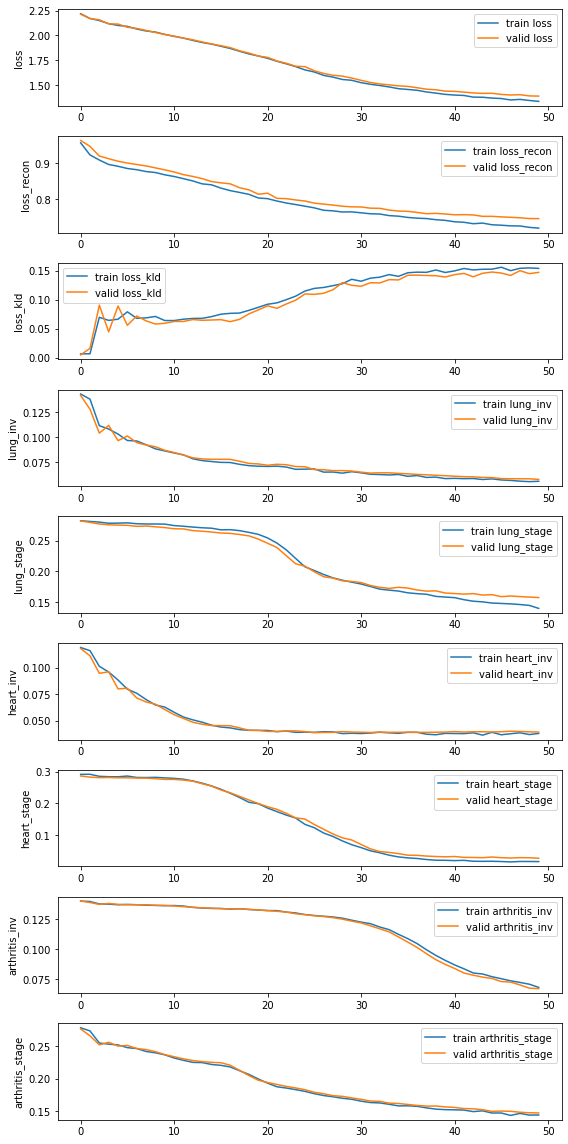

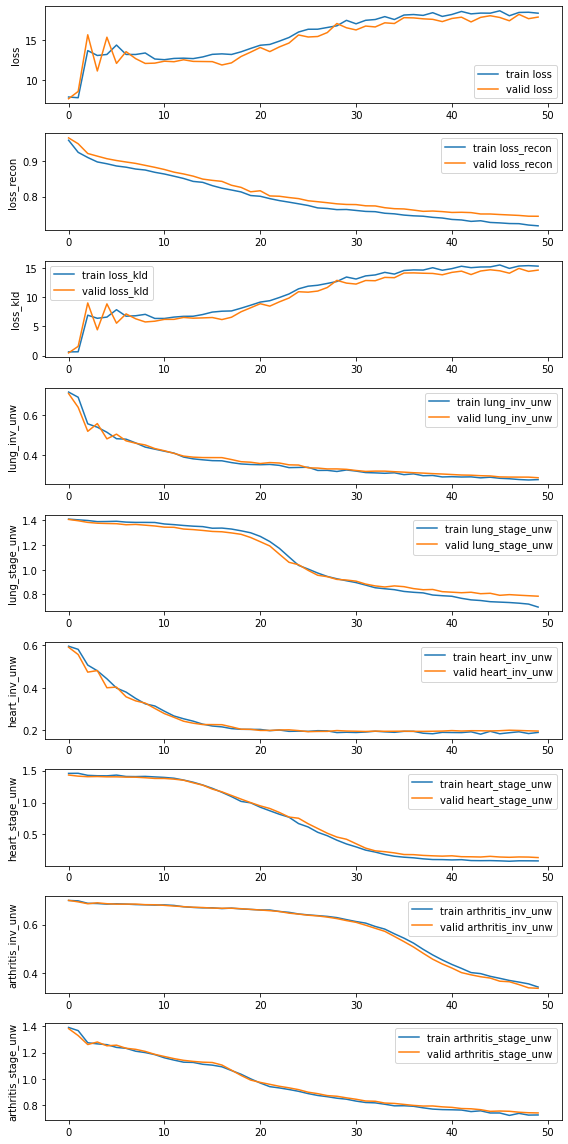

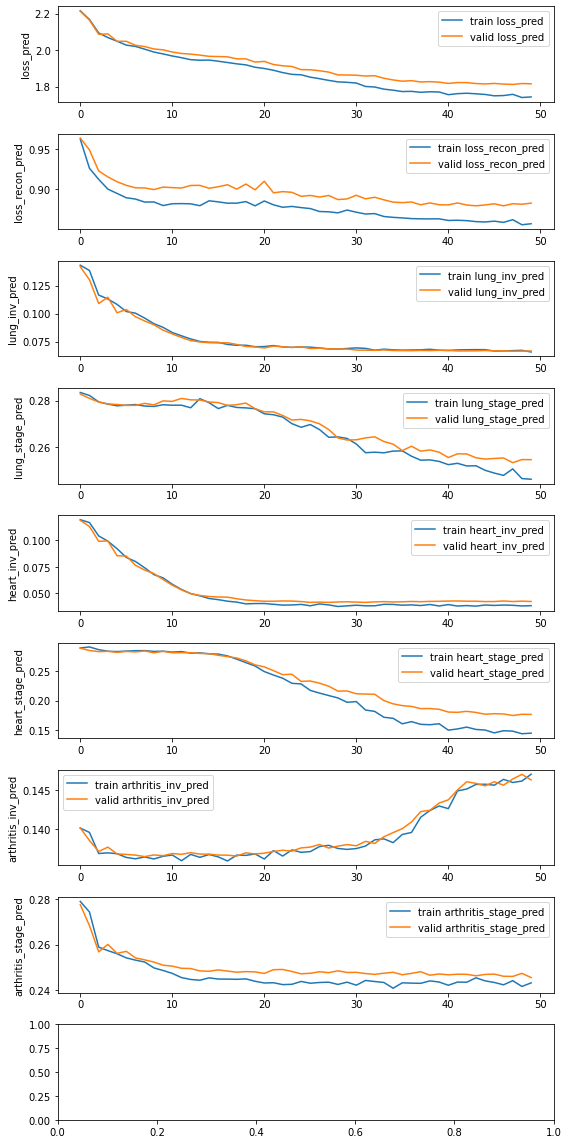

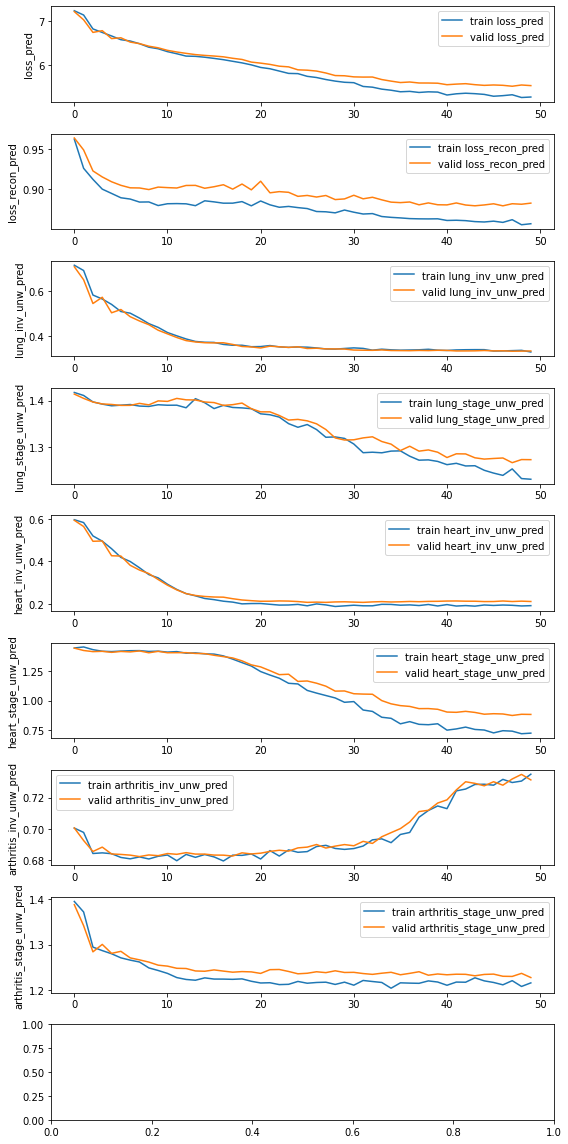

In [4]:
plot_losses(pipeline)